In [1]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import simpy
import xarray as xr

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock_new as lock_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
from opentnsim import zeesluisformulering as ZSF
from netCDF4 import Dataset
import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import folium
from shapely.ops import nearest_points, linemerge, split, snap, transform
import pyproj
import re
path = os.getcwd()

In [2]:
%load_ext autoreload
%autoreload 2

# Simulation parameters
## Time

In [3]:
output_path = path + '\\results\\Comparison\\'

In [4]:
t_sim = datetime.datetime(2023, 1, 1, 0, 0, 0)
t_start = datetime.datetime(2023, 2, 23, 0, 0, 0)
t_stop = datetime.datetime(2023, 2, 24, 0, 0, 0)

In [5]:
env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start
env.simulation_stop = t_stop

## Network

In [6]:
network = pickle.load(open(path+"\\geofiles\\PortNetwork.pickle", "rb"))
env.FG = network

## Vessel traffic service
### Hydrodynamic data

In [7]:
hydrodynamic_data = xr.load_dataset(path+"\\hydrodynamic_data\\hydrodynamic_data_modified2.nc")

### Vessel speed data

In [8]:
vessel_speed_data = pickle.load(open(path+'\\speed.pkl','rb'))

### Object

In [9]:
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=network, 
                                                                                hydrodynamic_start_time = hydrodynamic_data.TIME[0].values,
                                                                                hydrodynamic_information_path = path+"\\hydrodynamic_data\\hydrodynamic_data_modified2.nc", 
                                                                                vessel_speed_data_path = path + '\\speed.pkl')

## Lock complex object

In [10]:
# we add a lock to an edge in the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Sea Lock IJmuiden',
                                   start_node='lock_sea', #start node of lock complex (one edge)
                                   node_open='lock_sea', #node where doors are open at t=0  --->>> channel side, cause first vessel outbound
                                   end_node='lock_lake', #stop node of lock complex (one edge)
                                   approach_node_A = '5mile',
                                   approach_node_B = 'Houtrak',
                                   clustering_time = 0.5*60*60,
                                   distance_lock_doors_A_to_lineup_area_A=4800,
                                   distance_lock_doors_B_to_lineup_area_B=4800,
                                   distance_lock_doors_A_to_waiting_area_A=5000,
                                   distance_lock_doors_B_to_waiting_area_B=5000,
                                   distance_from_start_node_to_lock_doors_A = 1900.4821523031071,
                                   distance_from_end_node_to_lock_doors_B = 574.1330419091661,
                                   lock_length = 545,
                                   lock_width = 70,
                                   lock_depth = 17.75,
                                   disch_coeff = 0.65,
                                   gate_opening_time = 120,
                                   opening_area = 14*3*2.2,
                                   lineup_area_A_length=0,
                                   lineup_area_B_length=0,
                                   effective_lineup_area_A_length=545,
                                   effective_lineup_area_B_length=545,
                                   #levelling_time=1500,
                                   doors_opening_time=4.5*60,
                                   doors_closing_time=4.5*60,
                                   speed_reduction_factor_lineup_area_A=0.75,
                                   speed_reduction_factor_lineup_area_B=0.75,
                                   speed_reduction_factor_lock_chamber=0.75,
                                   sailing_in_time_gap = 180.,
                                   sailing_out_time_gap = 60.,
                                   time_step = 5,
                                   minimize_door_open_times = False,
                                   closing_doors_in_between_operations = False,
                                   sailing_time_before_opening_lock_doors = 6*60.,
                                   sailing_time_before_closing_lock_doors = 30.,
                                   detector_nodes = ['5mile','Houtrak'])

## Vessels

In [11]:
#We create a type element that schematisizes a vessel
def create_vessel(env, 
                  name, 
                  origin, 
                  destination, 
                  vessel_type, 
                  bound,
                  L, 
                  B, 
                  T,
                  v,
                  arrival_time):
    Vessel = type('Vessel',(lock_module.PassesLockComplex,
                            vessel_module.IsVessel,
                           ),{})    

    vessel = Vessel(
        **{ "env": env,
            "name": name,
            "origin": origin,
            "destination": destination,
            "type": vessel_type,
            "bound": bound,
            "L": L,
            "B": B,
            "T": T,
            "v": v,
            "arrival_time": arrival_time
        }
    )

    vessel.process = env.process(vessel.move())
    
    return vessel

In [12]:
ships = pickle.load(open(path+"\\ships0.pkl", "rb"))
ships[' '] = '...' 

#All ships till certain date and time
ships = ships[(ships['arrival'] <= pd.Timestamp(t_sim))]

ships[' '] = '...'
ships['locked'] = 0
ships['Lvirt'] = 0
ships['Tvirt'] = t_start
ships

,index,name,sluice,bound,length,beam,draught,volume,,arrival,Tlevel,ideal_out,locked,Lvirt,Tvirt


In [13]:
ships_df = pickle.load(open(path + "\\vessels\\ships.pickle",'rb'))
selected_ships = ships_df[(ships_df.departure > pd.Timestamp('2023-02-22 00:00:00',tz='UTC'))&
                          (ships_df.departure < pd.Timestamp('2023-03-09 00:00:00',tz='UTC'))]
selected_ships = selected_ships[selected_ships.index.isin(selected_ships['departure'].drop_duplicates().index)]

def to_real_datetime(T):
    for i,t in enumerate(T):
        T[i] = datetime.datetime.fromtimestamp((t-np.datetime64('1970-01-01'))/np.timedelta64(1,'ns')/1000000)
    return T

selected_ships.times = selected_ships.times.apply(to_real_datetime)

In [14]:
shippies_df = pickle.load(open(path + "\\Port_of_Amsterdam\\ships0.pkl",'rb'))
shippies_df = shippies_df[(shippies_df.arrival >= pd.Timestamp('2023-02-22 00:00:00'))&
                          (shippies_df.arrival <= pd.Timestamp('2023-03-09 00:00:00'))]

In [15]:
selected_vessel_names = shippies_df[(shippies_df.draught >= 8.0)|(shippies_df.length >= 200)|(shippies_df.beam >= 20)].name

In [16]:
selected_ships = selected_ships[selected_ships.name.isin(selected_vessel_names)]
selected_ships = selected_ships.sort_values('arrival')
selected_ships = selected_ships.reset_index(drop=True)

In [17]:
from shapely import wkt
selected_ships.coordinates = selected_ships.coordinates.apply(wkt.loads)
selected_ships

,name,departure,arrival,origin,destination,distance,duration,draught,geometry,times,...,sog,cog,speed,direction,acceleration,Zeesluis IJmuiden,Noordersluis,Middensluis,Zuidersluis,Kleine sluis
0,testschip-36593,2023-02-23 01:46:10+00:00,2023-02-23 02:54:44+00:00,POINT (4.387667179107665 52.47961807250976),POINT (4.607371807098389 52.46675872802733),15177.308261,0 days 01:08:34,12.8,LINESTRING (4.387667179107665 52.4796180725097...,"[2023-02-23T02:46:10.000000000, 2023-02-23T02:...",...,"[8.300000190734863, 8.300000190734863, 8.30000...","[80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80....","[3.9132514474371622, 3.6539808656556594, 6.362...","[85.27274147878244, 85.09398619010769, 85.0744...","[0.0, -0.0370386545402147, 1.3540841927358322,...",True,False,False,False,False
1,testschip-38412,2023-02-23 02:27:02+00:00,2023-02-23 04:07:31+00:00,POINT (4.774314880371093 52.40585327148436),POINT (4.611483097076417 52.46623229980468),14402.284488,0 days 01:40:29,10.6,LINESTRING (4.774314880371093 52.4058532714843...,"[2023-02-23T03:27:02.000000000, 2023-02-23T03:...",...,"[0.699999988079071, 0.8000000119209291, 0.8999...","[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....","[0.3664873203809877, 0.3780200111606618, 0.547...","[31.22390072536382, 33.860198378680515, 29.077...","[0.008301262639777464, 0.0010484264345158286, ...",True,False,False,False,False
2,testschip-37707,2023-02-23 02:14:40+00:00,2023-02-23 04:33:21+00:00,POINT (4.609562873840331 52.46672058105467),POINT (4.143704891204833 52.54983901977537),33591.910069,0 days 02:18:41,7.8,LINESTRING (4.609562873840331 52.4667205810546...,"[2023-02-23T03:14:40.000000000, 2023-02-23T03:...",...,"[0.5, 0.699999988079071, 0.8000000119209291, 1...","[275.0, 275.0, 275.0, 275.0, 275.0, 275.0, 275...","[0.17150664700943263, 0.42975883459433345, 0.5...","[298.385434690082, 263.05644715797195, 259.007...","[-0.02094041314885603, 0.02582521875849008, 0....",True,False,False,False,False
3,testschip-36593,2023-02-23 03:12:22+00:00,2023-02-23 04:51:13+00:00,POINT (4.607729911804199 52.46675491333008),POINT (4.74524211883545 52.42420196533202),11135.410064,0 days 01:38:51,12.8,LINESTRING (4.607729911804199 52.4667549133300...,"[2023-02-23T04:12:22.000000000, 2023-02-23T04:...",...,"[0.20000000298023202, 0.300000011920928, 0.300...","[93.0, 93.0, 93.0, 93.0, 93.0, 94.0, 94.0, 94....","[0.14253705472088926, 0.15495673217931955, 0.1...","[106.04634194843521, 104.61952083371439, 88.72...","[0.003094283388594306, 0.0012419677458430285, ...",True,False,False,False,False
4,testschip-27669,2023-02-23 02:21:59+00:00,2023-02-23 05:42:42+00:00,POINT (4.020022869110107 52.44522476196288),POINT (4.609172821044921 52.4666290283203),41708.303705,0 days 03:20:43,11.4,LINESTRING (4.020022869110107 52.4452247619628...,"[2023-02-23T03:21:59.000000000, 2023-02-23T03:...",...,"[0.40000000596046403, 0.699999988079071, 0.699...","[15.0, 34.0, 35.0, 36.0, 38.0, 40.0, 41.0, 43....","[0.103914535649909, 0.3625892879629739, 0.4411...","[206.35457870044368, 226.63304144916788, 229.3...","[0.0004096827577303575, 0.0016797061838510709,...",True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,testschip-35772,2023-03-08 16:48:43+00:00,2023-03-08 18:09:51+00:00,POINT (4.779501914978027 52.4100341796875),POINT (4.610997200012207 52.46635055541992),14050.159881,0 days 01:21:08,8.2,LINESTRING (4.779501914978027 52.4100341796875...,"[2023-03-08T17:48:43.000000000, 2023-03-08T17:...",...,"[1.399999976158142, 3.099999904632568, 3.09999...","[298.0, 335.0, 336.0, 338.0, 340.0, 341.0, 341...","[0.5407732896466942, 1.130645095226436, 3.2775...","[280.73755530638334, 291.1562251734742, 308.93...","[0.00276341132082327, 0.0032953732155292835, 2...",True,False,False,False,False
345,testschip-28453,2023-03-08 15:55:51+00:00,2023-03-08 19:02:10+00:00,POINT (4.61247682571411 52.466178894042955),POINT (3.7202799320220934 52.50282669067382),61752.439375,0 days 03:06:19,8.6,LINEST

In [18]:
selected_ships_combined = pd.DataFrame(columns=selected_ships.columns)

for index,ship_info in selected_ships.iterrows():
    next_ships_df = selected_ships.loc[(index+1):]
    next_ship_df= next_ships_df[next_ships_df.name == ship_info['name']]
    if not next_ship_df.empty:
        next_ship_series = next_ship_df.iloc[0]
        diff_hours = (next_ship_series.times[0] - ship_info.times[-1])/np.timedelta64(1,'h')
        if np.round(next_ship_series.draught,1) == np.round(ship_info.draught,1) and diff_hours <= 3:
            selected_ships_combined.loc[index,'name'] = ship_info['name']
            selected_ships_combined.loc[index,'departure'] = ship_info['departure']
            selected_ships_combined.loc[index,'arrival'] = next_ship_series['arrival']
            selected_ships_combined.loc[index,'origin'] = ship_info['origin']
            selected_ships_combined.loc[index,'destination'] = next_ship_series['destination']
            selected_ships_combined.loc[index,'distance'] = ship_info['distance']+next_ship_series['distance']
            selected_ships_combined.loc[index,'duration'] = ship_info['duration']+next_ship_series['duration']
            selected_ships_combined.loc[index,'draught'] = ship_info['draught']
            selected_ships_combined.loc[index,'geometry'] = linemerge([ship_info['geometry'],next_ship_series['geometry']])
            times = list(np.append(ship_info['times'],next_ship_series['times']))
            selected_ships_combined.at[index,'times'] = times
            selected_ships_combined.at[index,'coordinates'] = np.append(ship_info['coordinates'],next_ship_series['coordinates'])
            selected_ships_combined.at[index,'sog'] = np.append(ship_info['sog'],next_ship_series['sog'])
            selected_ships_combined.at[index,'cog'] = np.append(ship_info['cog'],next_ship_series['cog'])
            selected_ships_combined.at[index,'speed'] = np.append(ship_info['speed'],next_ship_series['speed'])
            selected_ships_combined.at[index,'direction'] = np.append(ship_info['direction'],next_ship_series['direction'])
            selected_ships_combined.at[index,'acceleration'] = np.append(ship_info['acceleration'],next_ship_series['acceleration'])
            selected_ships_combined.loc[index,'Zeesluis IJmuiden'] = True
            selected_ships_combined.loc[index,'Noordersluis'] = False
            selected_ships_combined.loc[index,'Middensluis'] = False
            selected_ships_combined.loc[index,'Zuidersluis'] = False
            selected_ships_combined.loc[index,'Kleine sluis'] = False
    else:
        selected_ships_combined.loc[index] = ship_info

In [19]:
selected_ships_combined = selected_ships_combined.reset_index(drop=True)

In [20]:
inbound_route = nx.dijkstra_path(env.FG,'5mile','Houtrak')
inbound_geometry = []
for node1, node2 in zip(inbound_route[:-1],inbound_route[1:]):
    inbound_geometry.append(env.FG.edges[node1, node2, 0]['geometry'])
inbound_geometry = linemerge(inbound_geometry)

outbound_route = nx.dijkstra_path(env.FG,'Houtrak','5mile')
outbound_geometry = []
for node1, node2 in zip(outbound_route[:-1],outbound_route[1:]):
    outbound_geometry.append(env.FG.edges[node1, node2, 0]['geometry'])
outbound_geometry = linemerge(outbound_geometry)

wgs84 = pyproj.CRS('EPSG:4326')
rd = pyproj.CRS('EPSG:28992')
wgs84_to_rd = pyproj.Transformer.from_crs(wgs84, rd, always_xy=True).transform

distance_ships = {}
time_ships = {}
colors = []
for index,ship in selected_ships_combined.iterrows():
    distance_ships[index] = []
    time_ships[index] = []
    
for index,ship in selected_ships_combined.iterrows():
    if ship.coordinates[0].x < ship.coordinates[-1].x:
        color = 'darkred'
        geometry = inbound_geometry
    else:
        color = 'navy'
        geometry = outbound_geometry

    mapped_points = []
    for coord in ship.coordinates:
        mapped_points.append(nearest_points(outbound_geometry, coord)[0])
    
    distance_sailed = []
    for point in mapped_points:
        result = split(outbound_geometry,point.buffer(0.000001))
        distance_sailed.append(-transform(wgs84_to_rd,result.geoms[0]).length+10500)
    
    distance_ships[index].extend(distance_sailed)
    time_ships[index].extend(ship.times)

(np.float64(19411.0), np.float64(19412.0))

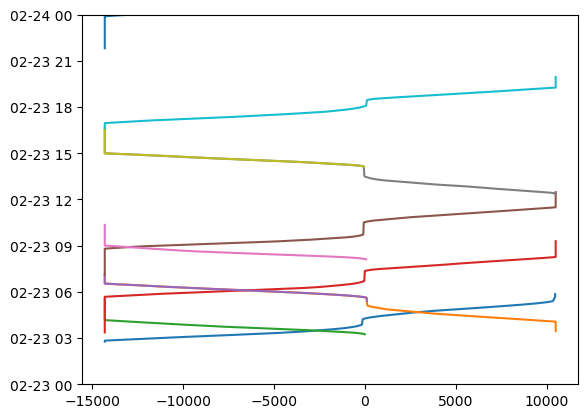

In [68]:
for index,ship in selected_ships_combined.iterrows():
    plt.plot(distance_ships[index],time_ships[index])
plt.ylim(pd.Timestamp('2023-02-23 00:00:00'),pd.Timestamp('2023-02-24 00:00:00'))

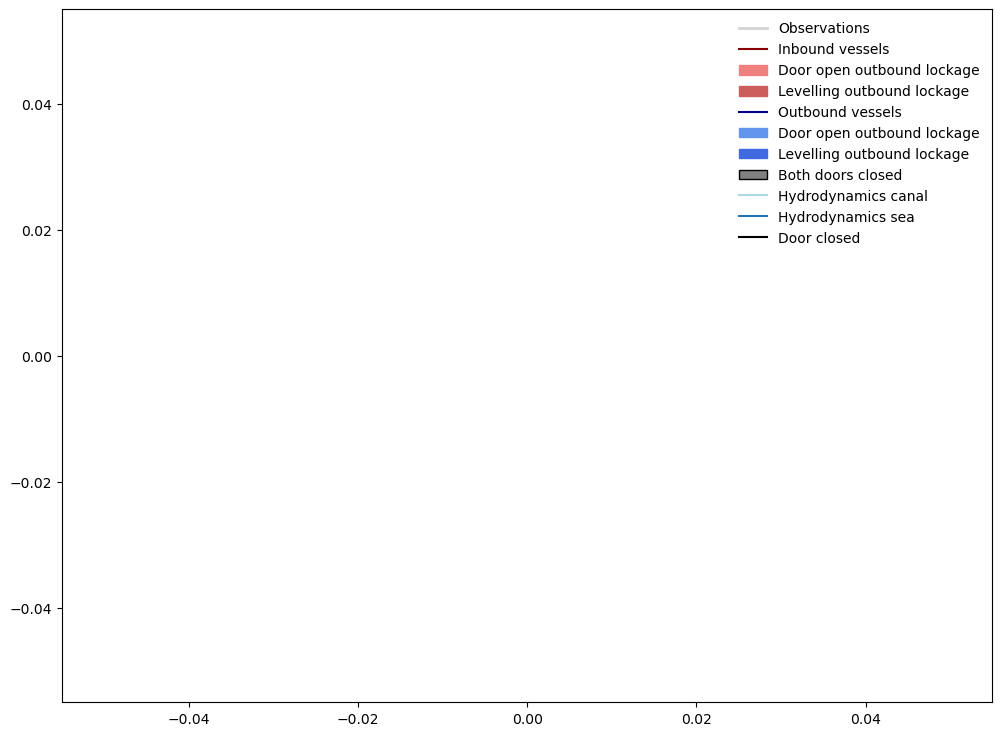

In [75]:
fig,ax = plt.subplots(figsize=[12,9])
ax.plot([],[],color='lightgrey',label='Observations',linewidth=2)
ax.plot([],[],color='darkred',label='Inbound vessels')
ax.fill([],[],color='lightcoral',label='Door open outbound lockage')
ax.fill([],[],color='indianred',label='Levelling outbound lockage')
ax.plot([],[],color='navy',label='Outbound vessels')
ax.fill([],[],color='cornflowerblue',label='Door open outbound lockage')
ax.fill([],[],color='royalblue',label='Levelling outbound lockage')
ax.fill([],[],color='grey',edgecolor='k',label='Both doors closed')
ax.plot([],[],color='lightblue',label='Hydrodynamics canal')
ax.plot([],[],color='C0',label='Hydrodynamics sea')
ax.plot([],[],color='k',label='Door closed')
ax.legend(frameon=False,ncols=1)

In [23]:
route=nx.dijkstra_path(env.FG,'Houtrak','lock_lake')
outbound_sailing_time = 0
for node1,node2 in zip(route[:-1],route[1:]):
    speed = vessel_speed_data[vessel_speed_data.index.isin([(node1,node2,0)])].iloc[0].iloc[0]
    distance = env.FG.edges[node1,node2,0]['length']
    outbound_sailing_time += distance/speed
    
route=nx.dijkstra_path(env.FG,'5mile','lock_sea')
inbound_sailing_time = 0
for node1,node2 in zip(route[:-1],route[1:]):
    speed = vessel_speed_data[vessel_speed_data.index.isin([(node1,node2,0)])].iloc[0].iloc[0]
    distance = env.FG.edges[node1,node2,0]['length']
    inbound_sailing_time += distance/speed

In [25]:
selected_ships_combined['length'] = selected_ships_combined.apply(lambda x: shippies_df[shippies_df.name == x['name']]['length'].iloc[0],axis=1)
selected_ships_combined['width'] = selected_ships_combined.apply(lambda x: shippies_df[shippies_df.name == x['name']]['beam'].iloc[0],axis=1)

In [ ]:
selected_ships_combined[df]

In [ ]:
selected_ships_combined.drop_duplicates('draught','

In [64]:
vessels = []
vessels_df = pd.DataFrame()
registered_delays = pd.DataFrame(columns=['name','arrival_time','bound','distance_start','distance_stop','time_start','time_stop'])

for index,ship_info in selected_ships_combined.iterrows():
    data = distance_ships[index]
    reversed_data = list(reversed(data))
    reversed_time = list(reversed(time_ships[index]))
    arrival_index = np.where(abs(np.diff(np.array(data))) != 0)[0][0]
    arrival_time = time_ships[index][np.where(abs(np.diff(np.array(data))) != 0)[0][0]]
    arrival_distance = distance_ships[index][np.where(abs(np.diff(np.array(data))) != 0)[0][0]]
    
    departure_time = reversed_time[np.where(abs(np.diff(np.array(reversed_data))) != 0)[0][0]]
    departure_distance = reversed_data[np.where(abs(np.diff(np.array(reversed_data))) != 0)[0][0]]
    
    if arrival_distance == -14306.994469211164:
        orig = '5mile'
        dest = 'Houtrak'
        bound = 'inbound'
        if departure_distance > 2000:
            registered_delays.loc[len(registered_delays),:] = [ship_info['name'],arrival_time,bound,arrival_distance,departure_distance,arrival_time,departure_time]
    elif arrival_distance == 10499.931084168276:
        orig = 'Houtrak'
        dest = '5mile'
        bound = 'outbound'
        if departure_distance < -2000:
            registered_delays.loc[len(registered_delays),:] = [ship_info['name'],arrival_time,bound,arrival_distance,departure_distance,arrival_time,departure_time]
    elif arrival_distance < 0:
        orig = '5mile'
        dest = 'Houtrak'
        bound = 'inbound'
        arrival_at_lock_index = np.where(np.array(data) > -1900)[0][0]
        arrival_time = time_ships[index][arrival_at_lock_index] - np.timedelta64(pd.Timedelta(seconds=inbound_sailing_time))
    elif arrival_distance > 0:
        orig = 'Houtrak'
        dest = '5mile'
        bound = 'outbound'
        arrival_at_lock_index = np.where(np.array(data) < 570)[0][0]
        arrival_time = time_ships[index][arrival_at_lock_index] - np.timedelta64(pd.Timedelta(seconds=outbound_sailing_time))

    index = len(vessels_df)
    vessels_df.loc[index,'name'] = ship_info['name']
    vessels_df.loc[index,'origin'] = orig
    vessels_df.loc[index,'destination'] = dest
    vessels_df.loc[index,'L'] = ship_info.length
    vessels_df.loc[index,'B'] = ship_info.width
    vessels_df.loc[index,'T'] = ship_info.draught
    vessels_df.loc[index,'bound'] = bound
    vessels_df.loc[index,'arrival_time'] = pd.Timestamp(arrival_time)

In [66]:
registered_delays.to_pickle(path + "\\vessels\\observed_vessels.pickle")

In [49]:
arrival_time,departure_time

(np.datetime64('2023-02-23T02:49:57.000000000'),
 np.datetime64('2023-02-23T05:51:13.000000000'))

In [ ]:
vessels_df = vessels_df.sort_values('arrival_time')
vessels_df = vessels_df.reset_index(drop=True)
vessels_df

In [ ]:
vessels_df.to_pickle(path + "\\vessels\\modelled_vessels.pickle")

In [ ]:
vessels = []
for index,vessel in vessels_df.iterrows(): 
    ship = create_vessel(env=env, 
                         name=vessel['name'], 
                         origin = vessel['origin'],
                         destination = vessel['destination'],
                         vessel_type='sea-going cargo vessel',
                         L=100,
                         B=50, 
                         T=vessel['T'],
                         v=4,
                         bound = vessel['bound'],
                         arrival_time = vessel['arrival_time'])
    vessels.append(ship)
    if index == 1:
        break

In [ ]:
# vessels = []

# inbound_ship = False
# outbound_ship = False

# for i,s in ships.iterrows():
#     if s.arrival < t_start:
#         continue
#     if s.arrival > t_stop-pd.Timedelta(4,'h'):
#         continue
#     if s.bound == 'inbound':
#         orig = '5mile'
#         dest = 'Houtrak'

#     elif s.bound == 'outbound':
#         orig = 'Houtrak'
#         dest = '5mile'
    
#     ship = create_vessel(env=env, 
#                          name=f'{s.name}', 
#                          origin = orig,
#                          destination = dest,
#                          vessel_type='inland vessel',
#                          L=s.length,
#                          B=s.beam, 
#                          T=s.draught,
#                     3    v=4,
#                          bound = s.bound,
#                          arrival_time = pd.to_datetime(s.arrival, format='%Y-%m-%d %H:%M:%S'))
    
#     vessels.append(ship)

#     if i == 10:
#         break

# Run 

In [ ]:
for vessel in vessels:
    print(vessel.id,vessel.bound,vessel.metadata['arrival_time'])

In [ ]:
route = nx.dijkstra_path(env.FG,'Houtrak','lock_lake')
distance = 0
for node1,node2 in zip(route[:-1],route[1:]):
    distance += env.FG.edges[node1,node2,0]['length']
distance

In [ ]:
pd.Timestamp('2023-02-23 02:04:53.664463')+pd.Timedelta(seconds=2692.335537)

In [ ]:
env.run(until=t_stop.timestamp())

In [ ]:
lock_I.vessel_planning

In [ ]:
lock_I.operation_planning

In [ ]:
vessel_logbooks = []
for i in range(len(vessels)):
    vessel_logbooks.append(pd.DataFrame(vessels[i].logbook))

lock_df = pd.DataFrame(lock_I.logbook)
lock_df.iloc[-50:]

In [ ]:
vessel_logbooks[1]

In [ ]:
hydrodynamic_times = hydrodynamic_data['TIME'].values
hydrodynamic_data.sel({'STATION':'lock_lake'})['Water level']

In [ ]:
lock = lock_I

In [ ]:
ZSF = ZSF.ZeesluisFormulering()

In [ ]:
import math

salinity_A = 28
salinity_B = 12

first_message = lock_df.iloc[0]
if first_message.Geometry == lock.start_node:
    initial_salinity = salinity_A
else:
    initial_salinity = salinity_B
initial_salinity = np.mean([salinity_A,salinity_B])
    
lock_salinity = np.ones(len(lock.water_level))*initial_salinity
total_intruded_salt_mass = 0
for index,message in lock_df.iterrows():
    if message.Message == 'Lock chamber converting stop':
        intruded_salt_mass = 0
        previous_message = lock_df.iloc[index-1]
        from_side = previous_message.Geometry
        to_side = message.Geometry
        time_index_start = int(np.absolute(hydrodynamic_times - np.datetime64(previous_message.Timestamp)).argmin())
        time_index_stop = int(np.absolute(hydrodynamic_times - np.datetime64(message.Timestamp)).argmin())
        water_level_A = hydrodynamic_data.sel({'STATION':lock.start_node})['Water level'].values[time_index_start]
        water_level_start = lock_I.water_level[time_index_start]
        salinity_lock_start = lock_salinity[time_index_start]
        water_level_stop = lock_I.water_level[time_index_stop]
        water_level_B = hydrodynamic_data.sel({'STATION':lock.end_node})['Water level'].values[time_index_stop]
        if to_side == lock.start_node:
            salinity_lock_stop,_ = ZSF.levelling_to_outer_harbour(S_K=salinity_lock_start,
                                                                  h_M=water_level_start,
                                                                  h_Z=water_level_A,
                                                                  S_M=salinity_B,
                                                                  S_Z=salinity_A,
                                                                  V_afw=0.,
                                                                  T_niv=(message.Timestamp-previous_message.Timestamp).total_seconds()/60)
        else:
            salinity_lock_stop,intruded_salt_mass =  ZSF.levelling_to_inner_harbour(S_K=salinity_lock_start,
                                                                                    h_M=water_level_B,
                                                                                    h_Z=water_level_start,
                                                                                    S_M=salinity_B,
                                                                                    S_Z=salinity_A,
                                                                                    V_opw=0.,
                                                                                    T_niv=(message.Timestamp-previous_message.Timestamp).total_seconds()/60)

        lock_salinity[time_index_stop:] = salinity_lock_stop
        total_intruded_salt_mass += intruded_salt_mass

    if message.Message == 'Lock doors closing stop':
        intruded_salt_mass = 0
        time_index_stop = int(np.absolute(hydrodynamic_times - np.datetime64(message.Timestamp)).argmin())
        t_step = hydrodynamic_times[1]-hydrodynamic_times[0]
        side_door_open = message.Geometry
        door_closed_time = message.Timestamp - 0.5*pd.Timedelta(seconds=lock.doors_closing_time)
        if index != 1:
            door_open_message = lock_df.loc[index-3]
            door_opened_time = door_open_message.Timestamp + 0.5*pd.Timedelta(seconds=lock.doors_opening_time)
            time_index_start = int(np.absolute(hydrodynamic_times - np.datetime64(door_open_message.Timestamp)).argmin())
        else:
            door_opened_time = lock.env.simulation_start
            time_index_start = int(0)

        salinity_lock_start = lock_salinity[time_index_start]
        water_level_A = hydrodynamic_data.sel({'STATION':lock.start_node})['Water level'].values[time_index_start]
        water_level_B = hydrodynamic_data.sel({'STATION':lock.end_node})['Water level'].values[time_index_stop]
        total_door_open_time = (door_closed_time - door_opened_time).total_seconds()
        if side_door_open == lock.start_node:
            door_open_phase_results = ZSF.door_opening_phase_outer_harbour(S_K=salinity_lock_start,
                                                                          h_Z=water_level_A,
                                                                          S_M=salinity_B,
                                                                          S_Z=salinity_A,
                                                                          V_opw=0.,
                                                                          V_afw=0.,
                                                                          T_op_Z=total_door_open_time,
                                                                          Q_spoelen=0.,
                                                                          Eff=1.0,
                                                                          fc_ci=1.65,
                                                                          par=True)
            salinity_lock_stop = door_open_phase_results[0]
            equilibrium_time = door_open_phase_results[8]
        else:
            door_open_phase_results = ZSF.door_opening_phase_inner_harbour(S_K=salinity_lock_start,
                                                                                         h_M=water_level_B,
                                                                                         S_M=salinity_B,
                                                                                         S_Z=salinity_A,
                                                                                         V_opw=0.,
                                                                                         V_afw=0.,
                                                                                         T_op_M=total_door_open_time,
                                                                                         Q_spoelen=0.,
                                                                                         Eff=1.0,
                                                                                         fc_ci=1.65,
                                                                                         par=True)
            salinity_lock_stop = door_open_phase_results[0]
            intruded_salt_mass = door_open_phase_results[1]
            equilibrium_time = door_open_phase_results[7]

        t_passed = 0
        salinity_diff = salinity_lock_stop-salinity_lock_start
        for time_index in np.arange(time_index_start,time_index_stop,1):
            t_passed += t_step/np.timedelta64(1,'s')
            lock_salinity[time_index:] = salinity_diff*math.tanh(t_passed/equilibrium_time)+salinity_lock_start
            
        total_intruded_salt_mass += intruded_salt_mass

In [ ]:
total_intruded_salt_mass/((28-12)*545*70*17.75)

In [ ]:
total_intruded_salt_mass,54391314.22538471/1000000

In [ ]:
route = nx.dijkstra_path(env.FG,'5mile','Houtrak')
distance = 0.
distance_speed = 0.
for node1,node2 in zip(route[:-1],route[1:]):
    distance += env.FG.edges[node1,node2,0]['length']
    distance_speed += vessel_speed_data[vessel_speed_data.index.isin([(node1,node2,0)])].iloc[0]*env.FG.edges[node1,node2,0]['length']

In [ ]:
delay = 0.
delays = []
for vessel in vessels:
    time_sailing_start = vessel.logbook[0]['Timestamp']
    time_sailing_stop = vessel.logbook[-1]['Timestamp']
    delay += (time_sailing_stop-time_sailing_start).total_seconds()-distance/5
    delays.append((time_sailing_stop-time_sailing_start).total_seconds()-distance/5)
print(np.max(delays)/60)

In [ ]:
delay/60/len(vessels) #0.7526336980557903

In [ ]:
start_node = '5mile'
end_node = 'Houtrak'
lock = lock_I
xlim_distance_to_lock_doors_A = -6000
xlim_distance_to_lock_doors_B = 6000
distance_ticks = 2000

substring_matches = ["Sailing from node","to node"]
vessel_times = []
vessel_distances = []
vessel_colors = []
for vessel_index,vessel in enumerate(vessels):
    vessel_df = pd.DataFrame(vessel.logbook)
    side = None
    lock_reached = False
    lock_passed = False
    approaching = 1
    direction = None
    color = None
    times = []
    distances = []
    for _,message in vessel_df.iterrows():
        node_start = None
        node_stop = None
        if all(x in message.Message for x in substring_matches):
            if not color and side != None:
                if not side:
                    color = 'darkred'
                elif side:
                    color = 'navy'
                    
            if message.Message == f'Sailing from node {lock.start_node} to node {lock.end_node} stop':
                lock_reached = True
            elif message.Message == f'Sailing from node {lock.end_node} to node {lock.start_node} stop':
                lock_reached = True
            
            m_start = re.search('Sailing from node (.+?) to node (.+?) start', message.Message)
            m_stop = re.search('Sailing from node (.+?) to node (.+?) stop', message.Message)
            if m_start:
                node_start = m_start.group(1)
                node_stop = m_start.group(2)
            elif m_stop:
                node_start = m_stop.group(1)
                node_stop = m_stop.group(2)
            
            if not (node_start == None or node_stop == None):
                if node_start == start_node:
                    side = 0
                elif node_start == end_node:
                    side = 1
    
                if direction == None and side != None:
                    direction = side
    
                lock_start_node = lock.start_node
                lock_end_node = lock.end_node
                lock_correction_start = lock.distance_from_start_node_to_lock_doors_A + 0.5*lock.lock_length
                lock_correction_stop = -(lock.distance_from_end_node_to_lock_doors_B + 0.5*lock.lock_length)
                sign = -1
                if direction:
                    lock_correction_stop, lock_correction_start = lock_correction_start, lock_correction_stop                
                    sign = 1
                    lock_start_node = lock.end_node
                    lock_end_node = lock.start_node
                    
                edge = (node_start,node_stop)
                
                distance_to_lock = 0
                distance_from_lock = 0
                if not lock_reached:
                    route = nx.dijkstra_path(vessel.env.FG,node_start,lock_start_node)
                    if m_start:
                        distance_to_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route)['Distance'].sum()
                    if m_stop:
                        distance_to_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route[1:])['Distance'].sum()
                    distances.append(sign*distance_to_lock-lock_correction_start)
                    times.append(message.Timestamp)
                else:
                    sign = -1*sign
                    route = nx.dijkstra_path(vessel.env.FG,lock_end_node,node_stop)
                    if m_start:
                        distance_from_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route[:-1])['Distance'].sum()
                    if m_stop:
                        distance_from_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route)['Distance'].sum()
                    distances.append(sign*distance_from_lock-lock_correction_stop)
                    times.append(message.Timestamp)
        elif 'Waiting' in message.Message:
            distances.append(distances[-1])
            times.append(message.Timestamp)
        else:
            if not side:
                distance_sailed,_ = vessel.env.vessel_traffic_service.provide_distance_over_network_to_location(lock.start_node,lock.end_node,message.Geometry)
                distance_sailed -= lock.distance_from_start_node_to_lock_doors_A + 0.5*lock.lock_length
            elif side:
                distance_sailed,_ = vessel.env.vessel_traffic_service.provide_distance_over_network_to_location(lock.end_node,lock.start_node,message.Geometry)
                distance_sailed = lock.distance_from_end_node_to_lock_doors_B + 0.5*lock.lock_length - distance_sailed
                
            distances.append(distance_sailed)
            times.append(message.Timestamp)
        
    vessel_distances.append(distances)
    vessel_times.append(times)
    vessel_colors.append(color)

fig,axes = plt.subplots(1,3,width_ratios=[6, 1, 1])
ax = axes[0]
first_message_info = lock_df.iloc[0]
simulation_start = pd.Timestamp(vessel.env.simulation_start)
simulation_stop = pd.Timestamp(vessel.env.simulation_stop)

door_closed_A = [[simulation_start]]
door_closed_B = [[simulation_start]]
replacement_wlev = pd.DataFrame(data={'Water level':lock.water_level},index=hydrodynamic_times)
nr_openings = 0
nr_closings = 0
nr_conversions = 0
for loc,info in lock_df.iterrows():   
    if info.name == 0:
        ylim_min = info.Timestamp - pd.Timedelta(minutes=5)
    if info.Message == 'Lock doors opening start': 
        nr_openings += 1
        door_opening_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            door_opening_stop = lock_df.loc[loc+1].Timestamp
        else:
            door_opening_stop = simulation_stop   

        direction = info.Geometry
        if info.name != 0 and lock_df.loc[loc-2].Geometry != direction:
            if direction == lock.start_node:
                color_doors = 'cornflowerblue'
                door_closed_A[-1].extend([door_opening_stop])
            else:
                color_doors = 'lightcoral'
                door_closed_B[-1].extend([door_opening_stop])    
        else:
            if direction == lock.start_node:
                color_doors = 'lightcoral'
                door_closed_A[-1].extend([door_opening_stop])
            else:
                color_doors = 'cornflowerblue'
                door_closed_B[-1].extend([door_opening_stop])
                
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [door_opening_start,door_opening_stop,door_opening_stop,door_opening_start],
                color=color_doors,edgecolor='none',zorder=2)

        if info.name == 0:
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [simulation_start,door_opening_start,door_opening_start,simulation_start],
                    color='grey',edgecolor='none',zorder=2)
        else:
            door_closing_stop = lock_df.loc[loc-1].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_opening_start,door_closing_stop,door_closing_stop,door_opening_start],
                    color='grey',edgecolor='none',zorder=2)

    if info.Message == 'Lock doors closing start':
        nr_closings += 1
        door_closing_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            door_closing_stop = lock_df.loc[loc+1].Timestamp
        else:
            door_closing_stop = simulation_stop
            
        direction = lock_df.loc[loc].Geometry

        if direction == lock.start_node:
            door_closed_A.append([door_closing_start])
            color_doors = 'lightcoral'
        else:
            door_closed_B.append([door_closing_start]) 
            color_doors = 'cornflowerblue'
            
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [door_closing_start,door_closing_stop,door_closing_stop,door_closing_start],
                color=color_doors,edgecolor='none',zorder=2)

        if info.name == len(lock_df)-2:
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_closing_stop,simulation_stop,simulation_stop,door_closing_stop],
                    color='grey',edgecolor='none',zorder=2)
            ylim_max = door_closing_stop + pd.Timedelta(minutes=5)

    if info.Message == 'Lock chamber converting start':
        nr_conversions += 1
        levelling_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            levelling_stop = lock_df.loc[loc+1].Timestamp
        else:
            levelling_stop = simulation_stop
            
        direction = lock_df.loc[loc].Geometry   
        if direction == lock.start_node:
            direction = 0
            color_levelling = 'indianred'
        else:
            direction = 1
            color_levelling = 'royalblue'

        same_direction = False
        if lock_df.loc[loc].Geometry == lock_df.loc[loc+1].Geometry:
            same_direction = True

        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [levelling_start,levelling_stop,levelling_stop,levelling_start],
                color=color_levelling,edgecolor='none',zorder=2)

        if loc != 0:
            door_closing_stop = lock_df.loc[loc-1].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_closing_stop,levelling_start,levelling_start,door_closing_stop],
                    color='grey',edgecolor='none',zorder=2)
            ylim_max = door_closing_stop + pd.Timedelta(minutes=5)
        else:
            doors_closed_open = lock.env.simulation_start
            doors_closed_stop = lock_df.loc[loc].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [doors_closed_open,doors_closed_stop,doors_closed_stop,doors_closed_open],
                    color='grey',edgecolor='none',zorder=2)

        tstart = np.datetime64(levelling_start)
        tstop = np.datetime64(levelling_stop)     
        t_index_stop = int(np.absolute(hydrodynamic_times - tstop).argmin())
        t_index_start = int(np.absolute(hydrodynamic_times - tstart).argmin())
        if t_index_start == t_index_stop:
            t_index_start -= 1
        wlevstart = lock.water_level[t_index_start]
        wlevstop = lock.water_level[t_index_stop]   
        tstep = pd.Timedelta(seconds=lock.time_step)
        _,z = lock.determine_levelling_time(t_start=tstart,wlev_init=wlevstart,same_direction=same_direction,direction=direction,prediction=False)
        z = z[~np.isnan(z)]
        wlev_diff0 = wlevstop - z[0] - wlevstart
        levelling_wlev = (wlevstop - z - wlev_diff0)
        levelling_times = np.datetime64(tstart) + np.arange(len(z))*tstep
        levelling_df = pd.DataFrame(data={'Water level':levelling_wlev},index=levelling_times)
        replacement_wlev = replacement_wlev.drop(replacement_wlev[(replacement_wlev.index >= tstart)&(replacement_wlev.index <= tstop)].index)
        replacement_wlev = pd.concat([replacement_wlev,levelling_df])
        replacement_wlev = replacement_wlev.sort_index()
        
for distances,times,color in zip(vessel_distances,vessel_times,vessel_colors):
    ax.plot(distances,times,color=color)

if len(door_closed_A[0]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_A[0].extend([simulation_start])
if len(door_closed_B[0]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_B[0].extend([simulation_start])
if len(door_closed_A[-1]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_A[-1].extend([simulation_stop])
if len(door_closed_B[-1]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_B[-1].extend([simulation_stop])

for door_closed in door_closed_A:
    ax.plot([-lock.lock_length/2,-lock.lock_length/2],door_closed,color='k')

for door_closed in door_closed_B:
    ax.plot([lock.lock_length/2,lock.lock_length/2],door_closed,color='k')

ylim_min = pd.Timestamp('2023-02-23 00:00:00')
ylim_max = pd.Timestamp('2023-02-23 21:00:00')

ax.axvline(-lock.lock_length/2,color='lightgrey',zorder=1)
ax.axvline(lock.lock_length/2,color='lightgrey',zorder=1)

xticklabels_approach_A = np.arange(xlim_distance_to_lock_doors_A,0+distance_ticks,distance_ticks)
xticklabels_approach_B = np.arange(0,xlim_distance_to_lock_doors_B+distance_ticks,distance_ticks)
xticks_approach_A = [tick-lock.lock_length/2 for tick in xticklabels_approach_A]
xticks_approach_B = [tick+lock.lock_length/2 for tick in xticklabels_approach_B]
xticks = np.append(xticks_approach_A,xticks_approach_B)
xticklabels = np.append(xticklabels_approach_A,xticklabels_approach_B)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(xlim_distance_to_lock_doors_A-lock.lock_length/2,xlim_distance_to_lock_doors_B+lock.lock_length/2)
ax.set_ylim(ylim_min,ylim_max)
ax.annotate(xy=(0.25,0.025),text='Sea',xycoords='axes fraction',horizontalalignment='center',color='C0')
ax.annotate(xy=(0.75,0.025),text='Canal',xycoords='axes fraction',horizontalalignment='center',color='lightblue')
ax.set_xlabel('Distance from lock chamber [m]',labelpad=8)
ax.set_ylabel('Time');

ax = axes[1]
ax.plot(hydrodynamic_data['Water level'][0].values,hydrodynamic_data.TIME,color='C0')
ax.plot(hydrodynamic_data['Water level'][1].values,hydrodynamic_data.TIME,color='lightblue')
ax.plot(replacement_wlev.values,replacement_wlev.index,color='k')
ax.set_xlim(-1.0,2.0)
ax.set_xticks(np.arange(-1,3,1))
ax.set_ylim(ylim_min,ylim_max)
ax.set_yticklabels([])
ax.set_xlabel('Water\nlevel\n[m]');

ax = axes[2]
ax.axvline(28,color='C0')
ax.axvline(12,color='lightblue')
ax.plot(lock_salinity,hydrodynamic_data.TIME,color='k')
ax.set_xlim(10,30)
ax.set_ylim(ylim_min,ylim_max)
ax.set_yticklabels([])
ax.set_xlabel('Salinity\n[PSU]')

fig.tight_layout()
fig.savefig(output_path+'not_reducing_door_open_time.png',format='png',dpi=500);

In [ ]:
lock.operation_planning

In [ ]:
for index,ax in enumerate(axes):
    ymin = pd.Timestamp('2023-02-23 2:55:00')
    ymax = pd.Timestamp('2023-02-23 4:30:00')
    ax.set_ylim(ymin,ymax)
        
axes[0].set_xlim(-5000-545/2,5000+545/2)
axes[1].set_xlim(-1,2)
fig
#fig.savefig(output_path+'simple_lock_passage_2way.png',format='png',dpi=500);

In [ ]:
lock_df.iloc[50:]

In [ ]:
break

In [ ]:
lock_df

In [ ]:
lock.vessel_planning

In [ ]:
lock.operation_planning

In [ ]:
# times = []
# levelling_times = []
# lock.time_step = 1
# for extra_time in np.arange(0,12.5*60*60,300):
#     lock.water_level = hydrodynamic_data.sel({'STATION':'lock_lake'})['Water level'].copy().values
#     lock.node_open = 'lock_lake'
#     times.append(datetime.datetime.fromtimestamp(lock.env.now+extra_time))
#     levelling_times.append(lock.determine_levelling_time(lock.env.now+extra_time,plot=False))

In [ ]:
# hydrodynamic_times = hydrodynamic_data['TIME']
# H_A = np.array([hydrodynamic_data['Water level'][0][np.absolute(hydrodynamic_times - np.datetime64(time)).argmin()] for time in times])
# H_B = np.array([hydrodynamic_data['Water level'][1][np.absolute(hydrodynamic_times - np.datetime64(time)).argmin()] for time in times])

In [ ]:
# mask = np.diff(H_A) > 0

In [ ]:
# plt.scatter(H_A[1:][mask]-H_B[1:][mask],np.array(levelling_times[1:])[mask])
# plt.scatter(H_A[1:][~mask]-H_B[1:][~mask],np.array(levelling_times[1:])[~mask])

In [ ]:
# plt.scatter(np.array(times[1:])[mask],H_A[1:][mask])
# plt.scatter(np.array(times[1:])[~mask],H_A[1:][~mask])

In [ ]:
# def align_yaxis(ax1, v1, ax2, v2):
#     """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
#     _, y1 = ax1.transData.transform((0, v1))
#     _, y2 = ax2.transData.transform((0, v2))
#     adjust_yaxis(ax2,(y1-y2)/2,v2)
#     adjust_yaxis(ax1,(y2-y1)/2,v1)

# def adjust_yaxis(ax,ydif,v):
#     """shift axis ax by ydiff, maintaining point v at the same location"""
#     inv = ax.transData.inverted()
#     _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
#     miny, maxy = ax.get_ylim()
#     miny, maxy = miny - v, maxy - v
#     if -miny>maxy or (-miny==maxy and dy > 0):
#         nminy = miny
#         nmaxy = miny*(maxy+dy)/(miny+dy)
#     else:
#         nmaxy = maxy
#         nminy = maxy*(miny+dy)/(maxy+dy)
#     ax.set_ylim(nminy+v, nmaxy+v)

# fig,ax = plt.subplots()
# ax.axhline(0,color='k',linewidth=0.5)
# ax.plot(times,H_A,color='C0',label='Offshore water level')
# ax.plot(times,H_B,color='skyblue',label='Inland water level')
# ax.plot(times,H_A-H_B,color='C1',label='Water level difference')
# ax.set_ylabel('Water level [m]',color='C0')
# ax.set_xlim(times[0],times[-1])
# ax2 = ax.twinx()
# ax2.plot(times,levelling_times,'C3')
# ax2.set_ylabel('Levelling time [s]',color='C3')
# xticks = ax.get_xticks()
# ax.set_xticklabels(labels=xticks,rotation=90)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M'))
# ax.set_ylim(-1.5,2)
# ax2.set_ylim(-100,360)
# ax.legend(bbox_to_anchor=[1.6,1],frameon=False)
# align_yaxis(ax, 0, ax2, 0)

In [ ]:
operation_planning = lock_I.operation_planning
vessel_planning = lock_I.vessel_planning

In [ ]:
operation_planning

In [ ]:
vessel_planning

In [ ]:
lock_x_A = 0.2
lock_x_B = 0.8
fig,ax = plt.subplots(figsize=[2,2*len(operation_planning)])
door_opening = pd.Timedelta(seconds=lock_I.doors_opening_time)
door_closing = pd.Timedelta(seconds=lock_I.doors_closing_time)

for operation_index,operation in operation_planning.iterrows():
    if operation.bound:
        color_doors = 'lightcoral'
        color_levelling = 'indianred'
    else:
        color_doors = 'cornflowerblue'
        color_levelling = 'royalblue'
        
    ax.fill([lock_x_A,lock_x_A,lock_x_B,lock_x_B],
            [operation.time_start_levelling-door_closing,
             operation.time_start_levelling,
             operation.time_start_levelling,
             operation.time_start_levelling-door_closing],
            color=color_doors)
    ax.fill([lock_x_A,lock_x_A,lock_x_B,lock_x_B],
            [operation.time_start_levelling,
             operation.time_stop_levelling,
             operation.time_stop_levelling,
             operation.time_start_levelling],
            color=color_levelling)
    ax.fill([lock_x_A,lock_x_A,lock_x_B,lock_x_B],
            [operation.time_stop_levelling,
             operation.time_stop_levelling+door_closing,
             operation.time_stop_levelling+door_closing,
             operation.time_stop_levelling],
            color=color_doors)

    for vessel in operation.vessels:
        vessel_info = vessel_planning[vessel_planning.index == vessel.id].iloc[0]
        in_lock = vessel_info.arrival_at_lock
        if in_lock < operation.time_sailing_in_start:
            in_lock = operation.time_sailing_in_start
        if not vessel_info.bound:
            x = [-0.5,0,0,0.5,0.5,1,1.5]
            vessel_color = 'navy'
        else:
            x = [1.5,1,1,0.5,0.5,0,-0.5]
            vessel_color = 'darkred'
        y = [vessel_info.arrival_at_lock,
             vessel_info.arrival_at_lock,
             in_lock,
             in_lock,operation.time_stop_levelling+door_closing,
             operation.time_stop_levelling+door_closing,
            operation.time_stop_levelling+door_closing]
        ax.plot(x,y,color=vessel_color,marker='o')
ax.set_xlim(-0.2,1.2)

In [ ]:
lock.operation_planning

In [ ]:
lock.vessel_planning

In [ ]:
pd.DataFrame(vessels[-1].logbook)

In [ ]:
pd.DataFrame(vessels[0].logbook)

In [ ]:
lock_df

In [ ]:
lock_I.operation_planning

In [ ]:
vessel.id in [vessel.id for vessel in lock_I.operation_planning.iloc[0].vessels]

In [ ]:
lock_I.operation_planning

In [ ]:
vessel.env.FG.edges['lock_sea','lock_lake',0]

In [ ]:
import matplotlib as mpl
inbound_color = mpl.colors.to_hex('firebrick')
outbound_color = mpl.colors.to_hex('navy')
network_color = mpl.colors.to_hex('grey')

m = folium.Map(location=[52.466,4.6], zoom_start = 10,tiles="cartodbpositron")

for edge in network.edges(data = True):
    points_x = list(edge[2]["geometry"].coords.xy[0])
    points_y = list(edge[2]["geometry"].coords.xy[1])
    line = []
    for i, _ in enumerate(points_x):
        line.append((points_y[i], points_x[i]))

    else:
        popup = folium.Popup(width=500, height=300)
        folium.PolyLine(line, color=network_color,weight = 3,tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

for node in network.nodes(data = True):
    points_x = list(node[1]["geometry"].coords.xy[0])
    points_y = list(node[1]["geometry"].coords.xy[1])
    
    point = []
    for i, _ in enumerate(points_x):
        point.append((points_y[i], points_x[i]))
    else:
        if 'terminal' in node[1]:
            terminal = node[1]['terminal']
            folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = terminal,popup =node[0]).add_to(m)
        else:
            folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)

# point = lock_I.location_lock_doors_A.xy[1][0],lock_I.location_lock_doors_A.xy[0][0]
# folium.Circle(point, radius=5,color='red',fill=False,fill_opacity=1,tooltip = 'Door A',popup = 'Door A').add_to(m)
# point = lock_I.location_lock_doors_B.xy[1][0],lock_I.location_lock_doors_B.xy[0][0]
# folium.Circle(point, radius=5,color='red',fill=False,fill_opacity=1,tooltip = 'Door B',popup = 'Door B').add_to(m)
# point = lock_I.lineup_area_A.start_location.xy[1][0],lock_I.lineup_area_A.start_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.lineup_area_A.end_location.xy[1][0],lock_I.lineup_area_A.end_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.lineup_area_B.start_location.xy[1][0],lock_I.lineup_area_B.start_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.lineup_area_B.end_location.xy[1][0],lock_I.lineup_area_B.end_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.waiting_area_A.location.xy[1][0],lock_I.waiting_area_A.location.xy[0][0]
# folium.Circle(point, radius=20,color='green',fill=True).add_to(m)
# point = lock_I.waiting_area_B.location.xy[1][0],lock_I.waiting_area_B.location.xy[0][0]
# folium.Circle(point, radius=20,color='green',fill=True).add_to(m)

for _,ship in selected_ships.iterrows():
    line = []
    color = inbound_color
    # bound = ships[ships.name == ship['name']].bound.iloc[0]
    # if bound == 'inbound':
    #     color = inbound_color
    # else:
    #     color = outbound_color
    for x,y in zip(ship.geometry.coords.xy[1],ship.geometry.coords.xy[0]):
        line.append((x,y))
    folium.PolyLine(line,color=color,opacity=0.5).add_to(m)

m

In [ ]:
# selected_ships = selected_ships.drop(417)
# selected_ships = selected_ships.drop(418)
# selected_ships = selected_ships.drop(119)
# selected_ships = selected_ships.drop(120)

In [ ]:
measurement_path = 'C:\\Users\\floorbakker\\Kolkmetingen_IJmuiden'
salinity_data = measurement_path + '\\Week01' + '\\Week01_Densitydata.xls' 
mean_data = measurement_path + '\\Week01' +  '\\Week01_Meandata.xls'
salinity_df = pd.read_excel(salinity_data, header=0,index_col=0,skiprows=[1])
mean_df = pd.read_excel(mean_data, header=0,index_col=0,skiprows=[1])

In [ ]:
gate_sea = mean_df[mean_df['Gate West status'] != 1.0][['Gate West status']]
door_closed_A_data = []
start_index = gate_sea.index[0]
for stop_index in gate_sea[gate_sea.index.diff(1) > np.timedelta64(15,'s')].index:
    iloc = gate_sea.index.get_loc(stop_index)
    door_closed_A_data.append([start_index,gate_sea.iloc[iloc-1].name])
    start_index = stop_index

gate_sea = mean_df[mean_df['Gate East status'] != 1.0][['Gate East status']]
door_closed_B_data = []
start_index = gate_sea.index[0]
for stop_index in gate_sea[gate_sea.index.diff(1) > np.timedelta64(15,'s')].index:
    iloc = gate_sea.index.get_loc(stop_index)
    door_closed_B_data.append([start_index,gate_sea.iloc[iloc-1].name])
    start_index = stop_index

In [ ]:
door_A_opening = []
door_B_opening = []
door_A_closing = []
door_B_closing = []

for door_closed,door_opened in door_closed_A_data:
    door_A_closing.append([door_closed,door_closed+pd.Timedelta(minutes=4)])
    door_A_opening.append([door_opened-pd.Timedelta(minutes=4),door_opened])

for door_closed,door_opened in door_closed_B_data:
    door_B_closing.append([door_closed,door_closed+pd.Timedelta(minutes=4)])
    door_B_opening.append([door_opened-pd.Timedelta(minutes=4),door_opened])

In [ ]:
def density_to_salinity(density):
    return 100*((density-999.7020815032)/(1078.7127620032-999.7020815032))

density = density_to_salinity(mean_df['rho Lock'])

In [ ]:
door_movement_df = pd.DataFrame(columns=['Time','Door','Movement','Color',])
for (_,door_closed),(door_opening,_) in zip(door_A_closing,door_A_opening):
    door_movement_df.loc[len(door_movement_df),:] = [door_closed,'A','closed','']                  
    door_movement_df.loc[len(door_movement_df),:] = [door_opening,'A','opening','']
for (_,door_closed),(door_opening,_) in zip(door_B_closing,door_B_opening):
    door_movement_df.loc[len(door_movement_df),:] = [door_closed,'B','closed','']                  
    door_movement_df.loc[len(door_movement_df),:] = [door_opening,'B','opening','']
door_movement_df = door_movement_df.sort_values('Time')
door_movement_df = door_movement_df.reset_index(drop=True)

In [ ]:
door_closed_times = []
levelling_times = []
inbound_color = 'lightcoral'
outbound_color = 'cornflowerblue'

door_movement_df.color = inbound_color
for index,movement in door_movement_df.iloc[1:].iterrows():
    previous_movement = door_movement_df.loc[index-1]
    if movement.Movement == 'opening' and previous_movement.Door == movement.Door:
        if movement.Door == 'A':
            door_movement_df.loc[index-1,'color'] = inbound_color
            door_movement_df.loc[index,'color'] = inbound_color
            color = 'indianred'
        else:
            door_movement_df.loc[index-1,'color'] = outbound_color
            door_movement_df.loc[index,'color'] = outbound_color
            color = 'royalblue'
            
        door_closed_times.append([previous_movement.Time,movement.Time,color])
    
    elif movement.Movement == 'opening' and previous_movement.Door != movement.Door:
        if movement.Door == 'A':
            door_movement_df.loc[index-1,'color'] = outbound_color
            door_movement_df.loc[index,'color'] = outbound_color
            color = 'royalblue'
        else:
            door_movement_df.loc[index-1,'color'] = inbound_color
            door_movement_df.loc[index,'color'] = inbound_color
            color = 'indianred'
            
        levelling_times.append([previous_movement.Time,movement.Time,color])

In [ ]:
wldif = 0.01
fig,axes = plt.subplots(1,3,width_ratios=[6, 1, 1])

ax = axes[0]
for door_closed,door_open,color in door_closed_times:
    ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
            [door_closed,door_open,door_open,door_closed],
            door_closed,color='grey')

    levelling_df = mean_df[(mean_df.index >= door_closed)&(mean_df.index <= door_open)]
    if not levelling_df[abs(levelling_df.WLlock.diff(1)) > wldif].empty:
        levelling_start = levelling_df[abs(levelling_df.WLlock.diff(1)) > wldif].iloc[0].name
        levelling_stop = levelling_df[abs(levelling_df.WLlock.diff(1)) > wldif].iloc[-1].name
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [levelling_start,levelling_stop,levelling_stop,levelling_start],
                door_closed,color=color,zorder=1)

for levelling_start,levelling_stop,color in levelling_times:
    ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
            [levelling_start,levelling_stop,levelling_stop,levelling_start],
            door_closed,color='grey')
    
    levelling_df = mean_df[(mean_df.index >= levelling_start)&(mean_df.index <= levelling_stop)]
    if not levelling_df[abs(levelling_df.WLlock.diff(1)) > wldif].empty:
        levelling_start = levelling_df[abs(levelling_df.WLlock.diff(1)) > wldif].iloc[0].name
        levelling_stop = levelling_df[abs(levelling_df.WLlock.diff(1)) > wldif].iloc[-1].name
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [levelling_start,levelling_stop,levelling_stop,levelling_start],
                door_closed,color=color,zorder=1)

for index,movement in door_movement_df.iloc[1:].iterrows():
    if movement.Movement == 'opening':
        door_opened = movement.Time + pd.Timedelta(minutes=4)
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [movement.Time,door_opened,door_opened,movement.Time],
                color=movement.color)

    elif movement.Movement == 'closed':
        door_closing = movement.Time - pd.Timedelta(minutes=4)
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [movement.Time,door_closing,door_closing,movement.Time],
                color=movement.color)

for door_closed in door_closed_A_data:
    ax.plot([-lock.lock_length/2,-lock.lock_length/2],door_closed,color='k')

for door_closed in door_closed_B_data:
    ax.plot([lock.lock_length/2,lock.lock_length/2],door_closed,color='k')

for _,ship in selected_ships.iterrows():
    if ship.coordinates[0].x < ship.coordinates[-1].x:
        color = 'darkred'
        geometry = inbound_geometry
    else:
        color = 'navy'
        geometry = outbound_geometry
    ax.plot(distance_ships[ship['name']],time_ships[ship['name']],color=color)
ax.set_xlim(-6000,6000)
ax.set_xlabel('Distance from lock chamber [m]',labelpad=8)
ax.set_ylabel('Time')
ax.annotate(xy=(0.25,0.025),text='Sea',xycoords='axes fraction',horizontalalignment='center',color='C0')
ax.annotate(xy=(0.75,0.025),text='Canal',xycoords='axes fraction',horizontalalignment='center',color='lightblue')

ax = axes[1]
ax.plot(mean_df.WLwestAH.values,mean_df.WLwestAH.index,color='C0')
ax.plot(mean_df.WLeastAH.values,mean_df.WLeastAH.index,color='lightblue')
ax.plot(mean_df.WLlock.values,mean_df.WLlock.index,color='k')
ax.set_xlim(-1,2)
ax.set_xticks([-1,0,1,2])
ax.set_xlabel('Water\nlevel\n[m]',labelpad=8)

ax = axes[2]
ax.axvline(12,color='lightblue')
ax.axvline(28,color='C0')
ax.plot(density.values,density.index,color='k')
ax.set_xlim(10,30)
ax.set_xlabel('Salinity\n[PSU]',labelpad=8)

for i,ax in enumerate(axes):
    ax.set_ylim(pd.Timestamp('2023-02-23 00:00:00'),pd.Timestamp('2023-02-23 21:00:00'))
    if i != 0:
        ax.set_yticklabels([])

fig.tight_layout()
fig.savefig(output_path+'data.png',format='png',dpi=500);

In [ ]:
for ax in axes:
    ax.set_ylim(pd.Timestamp('2023-02-23 6:00:00'),pd.Timestamp('2023-02-23 11:00:00'))
axes[0].set_xlim(-4000-545/2,4000+545/2)
#axes[1].set_xlim(-1,2)
fig
fig.savefig(output_path+'data_closeup.png',format='png',dpi=500)

In [ ]:
for i,ax in enumerate(axes):
    ax.set_ylim(pd.Timestamp('2023-02-23 00:00:00'),pd.Timestamp('2023-02-23 21:00:00'))
    if i != 0:
        ax.set_yticklabels([])
axes[0].set_xlim(-6000-545/2,6000+545/2)
axes[1].set_xlim(-1,2)
fig

In [ ]:
start_node = '5mile'
end_node = 'Houtrak'
lock = lock_I
xlim_distance_to_lock_doors_A = -6000
xlim_distance_to_lock_doors_B = 6000
distance_ticks = 2000

substring_matches = ["Sailing from node","to node"]
vessel_times = []
vessel_distances = []
vessel_colors = []
for vessel_index,vessel in enumerate(vessels):
    vessel_df = pd.DataFrame(vessel.logbook)
    side = None
    lock_reached = False
    lock_passed = False
    approaching = 1
    direction = None
    color = None
    times = []
    distances = []
    for _,message in vessel_df.iterrows():
        node_start = None
        node_stop = None
        if all(x in message.Message for x in substring_matches):
            if not color and side != None:
                if not side:
                    color = 'darkred'
                elif side:
                    color = 'navy'
                    
            if message.Message == f'Sailing from node {lock.start_node} to node {lock.end_node} stop':
                lock_reached = True
            elif message.Message == f'Sailing from node {lock.end_node} to node {lock.start_node} stop':
                lock_reached = True
            
            m_start = re.search('Sailing from node (.+?) to node (.+?) start', message.Message)
            m_stop = re.search('Sailing from node (.+?) to node (.+?) stop', message.Message)
            if m_start:
                node_start = m_start.group(1)
                node_stop = m_start.group(2)
            elif m_stop:
                node_start = m_stop.group(1)
                node_stop = m_stop.group(2)
            
            if not (node_start == None or node_stop == None):
                if node_start == start_node:
                    side = 0
                elif node_start == end_node:
                    side = 1
    
                if direction == None and side != None:
                    direction = side
    
                lock_start_node = lock.start_node
                lock_end_node = lock.end_node
                lock_correction_start = lock.distance_from_start_node_to_lock_doors_A + 0.5*lock.lock_length
                lock_correction_stop = -(lock.distance_from_end_node_to_lock_doors_B + 0.5*lock.lock_length)
                sign = -1
                if direction:
                    lock_correction_stop, lock_correction_start = lock_correction_start, lock_correction_stop                
                    sign = 1
                    lock_start_node = lock.end_node
                    lock_end_node = lock.start_node
                    
                edge = (node_start,node_stop)
                
                distance_to_lock = 0
                distance_from_lock = 0
                if not lock_reached:
                    route = nx.dijkstra_path(vessel.env.FG,node_start,lock_start_node)
                    if m_start:
                        distance_to_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route)['Distance'].sum()
                    if m_stop:
                        distance_to_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route[1:])['Distance'].sum()
                    distances.append(sign*distance_to_lock-lock_correction_start)
                    times.append(message.Timestamp)
                else:
                    sign = -1*sign
                    route = nx.dijkstra_path(vessel.env.FG,lock_end_node,node_stop)
                    if m_start:
                        distance_from_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route[:-1])['Distance'].sum()
                    if m_stop:
                        distance_from_lock = vessel.env.vessel_traffic_service.provide_sailing_distance_over_route(route)['Distance'].sum()
                    distances.append(sign*distance_from_lock-lock_correction_stop)
                    times.append(message.Timestamp)
        else:
            if not side:
                distance_sailed,_ = vessel.env.vessel_traffic_service.provide_distance_over_network_to_location(lock.start_node,lock.end_node,message.Geometry)
                distance_sailed -= lock.distance_from_start_node_to_lock_doors_A + 0.5*lock.lock_length
            elif side:
                distance_sailed,_ = vessel.env.vessel_traffic_service.provide_distance_over_network_to_location(lock.end_node,lock.start_node,message.Geometry)
                distance_sailed = lock.distance_from_end_node_to_lock_doors_B + 0.5*lock.lock_length - distance_sailed
                
            distances.append(distance_sailed)
            times.append(message.Timestamp)
        
    vessel_distances.append(distances)
    vessel_times.append(times)
    vessel_colors.append(color)

fig,axes = plt.subplots(1,3,width_ratios=[6, 1, 1])
ax = axes[0]
first_message_info = lock_df.iloc[0]
simulation_start = pd.Timestamp(vessel.env.simulation_start)
simulation_stop = pd.Timestamp(vessel.env.simulation_stop)

door_closed_A = [[simulation_start]]
door_closed_B = [[simulation_start]]
replacement_wlev = pd.DataFrame(data={'Water level':lock.water_level},index=hydrodynamic_times)

for loc,info in lock_df.iterrows():   
    if info.name == 0:
        ylim_min = info.Timestamp - pd.Timedelta(minutes=5)
    if info.Message == 'Lock doors opening start': 
        door_opening_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            door_opening_stop = lock_df.loc[loc+1].Timestamp
        else:
            door_opening_stop = simulation_stop   

        direction = info.Geometry
        if info.name != 0 and lock_df.loc[loc-2].Geometry != direction:
            if direction == lock.start_node:
                color_doors = 'cornflowerblue'
                door_closed_A[-1].extend([door_opening_stop])
            else:
                color_doors = 'lightcoral'
                door_closed_B[-1].extend([door_opening_stop])    
        else:
            if direction == lock.start_node:
                color_doors = 'lightcoral'
                door_closed_A[-1].extend([door_opening_stop])
            else:
                color_doors = 'cornflowerblue'
                door_closed_B[-1].extend([door_opening_stop])
                
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [door_opening_start,door_opening_stop,door_opening_stop,door_opening_start],
                color=color_doors,edgecolor='none',zorder=2)

        if info.name == 0:
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [simulation_start,door_opening_start,door_opening_start,simulation_start],
                    color='grey',edgecolor='none',zorder=2)
        else:
            door_closing_stop = lock_df.loc[loc-1].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_opening_start,door_closing_stop,door_closing_stop,door_opening_start],
                    color='grey',edgecolor='none',zorder=2)

    if info.Message == 'Lock doors closing start':
        door_closing_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            door_closing_stop = lock_df.loc[loc+1].Timestamp
        else:
            door_closing_stop = simulation_stop
            
        direction = lock_df.loc[loc].Geometry

        if direction == lock.start_node:
            door_closed_A.append([door_closing_start])
            color_doors = 'lightcoral'
        else:
            door_closed_B.append([door_closing_start]) 
            color_doors = 'cornflowerblue'
            
        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [door_closing_start,door_closing_stop,door_closing_stop,door_closing_start],
                color=color_doors,edgecolor='none',zorder=2)

        if info.name == len(lock_df)-2:
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_closing_stop,simulation_stop,simulation_stop,door_closing_stop],
                    color='grey',edgecolor='none',zorder=2)
            ylim_max = door_closing_stop + pd.Timedelta(minutes=5)

    if info.Message == 'Lock chamber converting start':
        levelling_start = lock_df.loc[loc].Timestamp
        if info.name != len(lock_df)-1:
            levelling_stop = lock_df.loc[loc+1].Timestamp
        else:
            levelling_stop = simulation_stop
            
        direction = lock_df.loc[loc].Geometry   
        if direction == lock.start_node:
            direction = 0
            color_levelling = 'indianred'
        else:
            direction = 1
            color_levelling = 'royalblue'

        same_direction = False
        if lock_df.loc[loc].Geometry == lock_df.loc[loc+1].Geometry:
            same_direction = True

        ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                [levelling_start,levelling_stop,levelling_stop,levelling_start],
                color=color_levelling,edgecolor='none',zorder=2)

        if loc != 0:
            door_closing_stop = lock_df.loc[loc-1].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [door_closing_stop,levelling_start,levelling_start,door_closing_stop],
                    color='grey',edgecolor='none',zorder=2)
            ylim_max = door_closing_stop + pd.Timedelta(minutes=5)
        else:
            doors_closed_open = lock.env.simulation_start
            doors_closed_stop = lock_df.loc[loc].Timestamp
            ax.fill([-lock.lock_length/2,-lock.lock_length/2,lock.lock_length/2,lock.lock_length/2],
                    [doors_closed_open,doors_closed_stop,doors_closed_stop,doors_closed_open],
                    color='grey',edgecolor='none',zorder=2)

        tstart = np.datetime64(levelling_start)
        tstop = np.datetime64(levelling_stop)     
        t_index_stop = int(np.absolute(hydrodynamic_times - tstop).argmin())
        t_index_start = int(np.absolute(hydrodynamic_times - tstart).argmin())
        if t_index_start == t_index_stop:
            t_index_start -= 1
        wlevstart = lock.water_level[t_index_start]
        wlevstop = lock.water_level[t_index_stop]     
        tstep = pd.Timedelta(seconds=lock.time_step)
        _,z = lock.determine_levelling_time(t_start=tstart,wlev_init=wlevstart,same_direction=same_direction,direction=direction,prediction=True)
        z = z[~np.isnan(z)]
        wlev_diff0 = wlevstop - z[0] - wlevstart
        levelling_wlev = (wlevstop - z - wlev_diff0)
        levelling_times = np.datetime64(tstart) + np.arange(len(z))*tstep
        levelling_df = pd.DataFrame(data={'Water level':levelling_wlev},index=levelling_times)
        replacement_wlev = replacement_wlev.drop(replacement_wlev[(replacement_wlev.index >= tstart)&(replacement_wlev.index <= tstop)].index)
        replacement_wlev = pd.concat([replacement_wlev,levelling_df])
        replacement_wlev = replacement_wlev.sort_index()
        
for distances,times,color in zip(vessel_distances,vessel_times,vessel_colors):
    ax.plot(distances,times,color=color)

if len(door_closed_A[0]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_A[0].extend([simulation_start])
if len(door_closed_B[0]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_B[0].extend([simulation_start])
if len(door_closed_A[-1]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_A[-1].extend([simulation_stop])
if len(door_closed_B[-1]) == 1:
    simulation_stop = pd.Timestamp(datetime.datetime.fromtimestamp(vessel.env.now))
    door_closed_B[-1].extend([simulation_stop])

for door_closed in door_closed_A:
    ax.plot([-lock.lock_length/2,-lock.lock_length/2],door_closed,color='k')

for door_closed in door_closed_B:
    ax.plot([lock.lock_length/2,lock.lock_length/2],door_closed,color='k')

ylim_min = pd.Timestamp('2023-02-23 00:00:00')
ylim_max = pd.Timestamp('2023-02-23 21:00:00')

ax.axvline(-lock.lock_length/2,color='lightgrey',zorder=1)
ax.axvline(lock.lock_length/2,color='lightgrey',zorder=1)

xticklabels_approach_A = np.arange(xlim_distance_to_lock_doors_A,0+distance_ticks,distance_ticks)
xticklabels_approach_B = np.arange(0,xlim_distance_to_lock_doors_B+distance_ticks,distance_ticks)
xticks_approach_A = [tick-lock.lock_length/2 for tick in xticklabels_approach_A]
xticks_approach_B = [tick+lock.lock_length/2 for tick in xticklabels_approach_B]
xticks = np.append(xticks_approach_A,xticks_approach_B)
xticklabels = np.append(xticklabels_approach_A,xticklabels_approach_B)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(xlim_distance_to_lock_doors_A-lock.lock_length/2,xlim_distance_to_lock_doors_B+lock.lock_length/2)
ax.set_ylim(ylim_min,ylim_max)
ax.annotate(xy=(0.25,0.025),text='Sea',xycoords='axes fraction',horizontalalignment='center',color='C0')
ax.annotate(xy=(0.75,0.025),text='Canal',xycoords='axes fraction',horizontalalignment='center',color='lightblue')
ax.set_xlabel('Distance from lock chamber [m]',labelpad=8)
ax.set_ylabel('Time');

ax = axes[1]
ax.plot(hydrodynamic_data['Water level'][0].values,hydrodynamic_data.TIME,color='C0')
ax.plot(hydrodynamic_data['Water level'][1].values,hydrodynamic_data.TIME,color='lightblue')
ax.plot(replacement_wlev.values,replacement_wlev.index,color='k')
ax.set_xlim(-1.0,2.0)
ax.set_xticks(np.arange(-1,3,1))
ax.set_ylim(ylim_min,ylim_max)
ax.set_yticklabels([])
ax.set_xlabel('Water\nlevel\n[m]');

ax = axes[2]
ax.axvline(28,color='C0')
ax.axvline(12,color='lightblue')
ax.plot(lock_salinity,hydrodynamic_data.TIME,color='k')
ax.set_xlim(10,30)
ax.set_ylim(ylim_min,ylim_max)
ax.set_yticklabels([])
ax.set_xlabel('Salinity\n[PSU]')

ax = axes[0]
for door_closed in door_closed_A_data:
    ax.plot([-lock.lock_length/2,-lock.lock_length/2],door_closed,color='lightgrey',zorder=-1)

for door_closed in door_closed_B_data:
    ax.plot([lock.lock_length/2,lock.lock_length/2],door_closed,color='lightgrey',zorder=-1)

for _,ship in selected_ships.iterrows():
    if ship.coordinates[0].x < ship.coordinates[-1].x:
        color = 'lightgrey'
        geometry = inbound_geometry
    else:
        color = 'lightgrey'
        geometry = outbound_geometry
    ax.plot(distance_ships[ship['name']],time_ships[ship['name']],color=color,zorder=-1)

ax = axes[1]
ax.plot(mean_df.WLlock.values,mean_df.WLlock.index,color='lightgrey',zorder=-1)
ax.set_xlim(-1,2)
ax.set_xticks([-1,0,1,2])
ax.set_xlabel('Water\nlevel\n[m]',labelpad=8)

ax = axes[2]
ax.plot(density.values,density.index,color='lightgrey',zorder=-1)
ax.set_xlim(10,30)
ax.set_xlabel('Salinity\n[PSU]',labelpad=8)

fig.tight_layout()
fig.savefig(output_path+'comparison.png',format='png',dpi=500);

In [ ]:
for ax in axes:
    ax.set_ylim(pd.Timestamp('2023-02-23 6:00:00'),pd.Timestamp('2023-02-23 11:00:00'))
axes[0].set_xlim(-4000-545/2,4000+545/2)
#axes[1].set_xlim(-1,2)
fig.savefig(output_path+'comparison_closeup.png',format='png',dpi=500);

In [ ]:
env.FG.add_edge('8862497','lock_sea',geometry=LineString([env.FG.nodes['8862497']['geometry'],env.FG.nodes['lock_sea']['geometry']]))
env.FG.remove_node('8867768')

In [ ]:
import matplotlib as mpl
inbound_color = mpl.colors.to_hex('firebrick')
outbound_color = mpl.colors.to_hex('navy')
network_color = mpl.colors.to_hex('grey')

m = folium.Map(location=[52.466,4.6], zoom_start = 9,tiles="cartodbpositron")

for edge in network.edges(data = True):
    points_x = list(edge[2]["geometry"].coords.xy[0])
    points_y = list(edge[2]["geometry"].coords.xy[1])
    line = []
    for i, _ in enumerate(points_x):
        line.append((points_y[i], points_x[i]))

    else:
        popup = folium.Popup(width=500, height=300)
        folium.PolyLine(line, color=network_color,weight = 3,tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

for node in network.nodes(data = True):
    points_x = list(node[1]["geometry"].coords.xy[0])
    points_y = list(node[1]["geometry"].coords.xy[1])
    
    point = []
    for i, _ in enumerate(points_x):
        point.append((points_y[i], points_x[i]))
    else:
        if 'terminal' in node[1]:
            terminal = node[1]['terminal']
            folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = terminal,popup =node[0]).add_to(m)
        else:
            folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)

# point = lock_I.location_lock_doors_A.xy[1][0],lock_I.location_lock_doors_A.xy[0][0]
# folium.Circle(point, radius=5,color='red',fill=False,fill_opacity=1,tooltip = 'Door A',popup = 'Door A').add_to(m)
# point = lock_I.location_lock_doors_B.xy[1][0],lock_I.location_lock_doors_B.xy[0][0]
# folium.Circle(point, radius=5,color='red',fill=False,fill_opacity=1,tooltip = 'Door B',popup = 'Door B').add_to(m)
# point = lock_I.lineup_area_A.start_location.xy[1][0],lock_I.lineup_area_A.start_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.lineup_area_A.end_location.xy[1][0],lock_I.lineup_area_A.end_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.lineup_area_B.start_location.xy[1][0],lock_I.lineup_area_B.start_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.lineup_area_B.end_location.xy[1][0],lock_I.lineup_area_B.end_location.xy[0][0]
# folium.Circle(point, radius=20,color='yellow',fill=True).add_to(m)
# point = lock_I.waiting_area_A.location.xy[1][0],lock_I.waiting_area_A.location.xy[0][0]
# folium.Circle(point, radius=20,color='green',fill=True).add_to(m)
# point = lock_I.waiting_area_B.location.xy[1][0],lock_I.waiting_area_B.location.xy[0][0]
# folium.Circle(point, radius=20,color='green',fill=True).add_to(m)

# for _,ship in selected_ships.iterrows():
#     line = []
#     color = inbound_color
#     bound = ships[ships.name == ship['name']].bound.iloc[0]
#     if bound == 'inbound':
#         color = inbound_color
#     else:
#         color = outbound_color
#     for x,y in zip(ship.geometry.coords.xy[1],ship.geometry.coords.xy[0]):
#         line.append((x,y))
#     folium.PolyLine(line,color=color,opacity=0.5).add_to(m)

m

In [ ]:
geofile_path = path + "\\geofiles\\"
geofile_path

In [ ]:
import geopandas as gpd

In [ ]:
tss = gpd.read_file(geofile_path+'traffic_separation_scheme\export (88).geojson')

In [ ]:
tss.geometry.plot()

In [ ]:
def linestring_to_polygon(gdf):
    geom = [x for x in gdf.geometry]
    all_coords = mapping(geom[0])['coordinates']
    lats = [x[1] for x in all_coords]
    lons = [x[0] for x in all_coords]
    polyg = Polygon(zip(lons, lats))
    return gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polyg])

In [ ]:
# srcDS = gdal.OpenEx(path+'\\geofiles\\locks\\Sluizencomplex IJmuiden.kml')
# ds = gdal.VectorTranslate(path + '\\geofiles\\locks\\Sluizencomplex_IJmuiden.geojson', srcDS, format='GeoJSON')
locks = []
for file_lock in os.listdir(path+"\\geofiles\\locks"):
    if file_lock.endswith((".geojson")):
        locks.append(gpd.read_file(path+"\\geofiles\\locks\\"+file_lock))
locks_df = pd.concat(locks)
for loc,info in locks_df.iterrows():
    sluices_linestrings = info.geometry
sluices = []
for sluice_linstring in sluices_linestrings.geoms:
    sluices.append(Polygon(shapely.ops.transform(lambda x, y, z=None: (x, y), sluice_linstring)))
sluices = gpd.GeoDataFrame(data={'Name':['Zeesluis','Noordersluis','Middensluis','Zuidersluis','Kleine Sluis']},geometry=sluices,crs='EPSG:4326')

In [ ]:
traffic_separation_scheme = []
for file_water_area in os.listdir(path+"\\geofiles\\traffic_separation_scheme"):
    traffic_separation_scheme.append(gpd.read_file(path+"\\geofiles\\traffic_separation_scheme\\"+file_water_area))
traffic_separation_scheme_df = pd.concat(traffic_separation_scheme)
traffic_separation_scheme_df = traffic_separation_scheme_df.drop(index=16)

In [ ]:
tss_boundaries = traffic_separation_scheme_df.iloc[[9,10,11,13,14]]
for loc,info in tss_boundaries.iterrows():
    tss_boundaries.loc[loc,'geometry'] = Polygon(info.geometry)

In [ ]:
anchorage_areas = []
for file_anchorage_area in os.listdir(path+"\\geofiles\\anchorage_areas"):
    anchorage_areas.append(gpd.read_file(path+"\\geofiles\\anchorage_areas\\"+file_anchorage_area))
anchorage_areas_df = pd.concat(anchorage_areas)
anchorage_areas_df.loc[2,'geometry'] = Polygon(anchorage_areas_df.loc[2,'geometry'])

In [ ]:
water_areas = []
for file_water_area in os.listdir(path+"\\geofiles\\water_areas"):
    if file_water_area.endswith((".geojson")):
        water_areas.append(gpd.read_file(path+"\\geofiles\\water_areas\\"+file_water_area))
water_areas_df = pd.concat(water_areas)

In [ ]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString, mapping, MultiPolygon
import shapely

terminal_areas = []
for file_terminal_area in os.listdir(path+"\\geofiles\\terminal_areas"):
    terminal_areas.append(gpd.read_file(path+"\\geofiles\\terminal_areas\\"+file_terminal_area))
terminal_areas_df = pd.concat(terminal_areas)
terminal_areas_df = terminal_areas_df.reset_index(drop=True)
cruise_terminal_amsterdam = linestring_to_polygon(terminal_areas_df.loc[22:31])
cruise_terminal_amsterdam_berth = linestring_to_polygon(terminal_areas_df.loc[[27]])
cruise_terminal_amsterdam = pd.concat([cruise_terminal_amsterdam,cruise_terminal_amsterdam_berth])
terminal_areas_df = terminal_areas_df.drop(index=np.arange(22,32))
terminal_areas_df = pd.concat([terminal_areas_df,cruise_terminal_amsterdam])
terminals_polygon = shapely.ops.unary_union([polygon for polygon in terminal_areas_df.geometry])
water_polygon = shapely.ops.unary_union([polygon for polygon in water_areas_df.geometry])
terminals_polygon = terminals_polygon.difference(water_polygon)
terminals = gpd.GeoDataFrame(geometry=[terminals_polygon],crs='EPSG:4326')

In [ ]:
breakwater_point = Point(4.532787,52.466392)
breakwater_point_utm = transform(wgs_to_utm,breakwater_point)
mile5_utm = breakwater_point_utm.buffer(5000*(1/0.621371192))
mile5 = transform(utm_to_wgs,mile5_utm)

In [ ]:
mile5 = split(mile5, breakwater_transect).geoms[1].exterior
points = []
for x,y in zip(mile5.coords.xy[0][:-1],mile5.coords.xy[1][:-1]):
    points.append(Point(x,y))
mile5 = LineString(points)

In [ ]:
dlon = 4.739575-4.740612
dlat = 52.429811-52.432430
entrance_nsc = LineString([Point(4.739575+dlon*5,52.429811+dlat*5),Point(4.740612-dlon*5,52.432430-dlat*5)])

In [ ]:
fig,ax = plt.subplots(figsize=[28,18])
terminals.plot(ax=ax,facecolor='lightgrey')
traffic_separation_scheme_df.plot(ax=ax,edgecolor='violet')
tss_boundaries.plot(ax=ax,edgecolor='violet',facecolor='violet')
anchorage_areas_df.plot(ax=ax,edgecolor='limegreen',facecolor='none',zorder=1)
plt.plot(*mile5.coords.xy,color='k')
plt.plot(*entrance_nsc.coords.xy,color='k')
sluices.plot(ax=ax,facecolor='none',edgecolor='k')
ax.set_xlim([3.6,5.0])
ax.set_ylim([52.30,52.65]);

In [ ]:
sluices

In [ ]:
terminals["style"] = [{"fillColor": mpl.colors.to_hex('grey'), "weight": 1, "color":  mpl.colors.to_hex('darkgrey')}]*len(terminals)
sluices["style"] = [{"fillColor": mpl.colors.to_hex('cornflowerblue'), "weight": 1, "color":  mpl.colors.to_hex('cornflowerblue')}]*len(sluices)
tss_boundaries["style"] = [{"fillColor": mpl.colors.to_hex('violet'), "weight": 1, "color":  mpl.colors.to_hex('violet')}]*len(tss_boundaries)
traffic_separation_scheme_df["style"] = [{"fillColor": mpl.colors.to_hex('violet'), "weight": 1, "color":  mpl.colors.to_hex('violet')}]*len(traffic_separation_scheme_df)
anchorage_areas_df["style"] = [{"fillColor": mpl.colors.to_hex('limegreen'), "weight": 1, "color":  mpl.colors.to_hex('limegreen')}]*len(anchorage_areas_df)

In [ ]:
ships_filtered = ships_df[ships_df.distance > 1000]
ships_filtered.origin = ships_filtered.origin.apply(wkt.loads)
ships_filtered.destination = ships_filtered.destination.apply(wkt.loads)
ships_filtered['bound'] = ships_filtered.apply(lambda x: 'inbound' if x.origin.x < x.destination.x else 'outbound',axis=1)

In [ ]:
inbound_ships = ships_filtered[ships_filtered.bound == 'inbound']
inbound_ships['style'] = [{"fillColor": mpl.colors.to_hex('firebrick'), "weight": 1, "color":  mpl.colors.to_hex('firebrick'), "opacity":  0.05}]*len(inbound_ships)
outbound_ships = ships_filtered[ships_filtered.bound == 'outbound']
outbound_ships['style'] = [{"fillColor": mpl.colors.to_hex('navy'), "weight": 1, "color":  mpl.colors.to_hex('navy'), "opacity":  0.05}]*len(outbound_ships)

In [ ]:
inbound_ships_selected = inbound_ships[inbound_ships['Zeesluis IJmuiden']|inbound_ships['Noordersluis']]
outbound_ships_selected = outbound_ships[outbound_ships['Zeesluis IJmuiden']|outbound_ships['Noordersluis']]
inbound_ships_plot = inbound_ships_selected[['arrival','geometry','style']]
outbound_ships_plot = outbound_ships_selected[['arrival','geometry','style']]

In [ ]:
inbound_ships_plot = gpd.GeoDataFrame(inbound_ships_plot)
outbound_ships_plot = gpd.GeoDataFrame(outbound_ships_plot)
inbound_ships_plot = inbound_ships_plot.set_crs(crs={'init': 'epsg:4326'})
outbound_ships_plot = outbound_ships_plot.set_crs(crs={'init': 'epsg:4326'})

In [ ]:
import matplotlib as mpl

In [ ]:
ships_plot = pd.concat([inbound_ships_plot,outbound_ships_plot])
ships_plot = ships_plot.sort_values('arrival')
ships_plot = ships_plot[['geometry','style']]

In [ ]:
inbound_color = mpl.colors.to_hex('firebrick')
outbound_color = mpl.colors.to_hex('navy')
network_color = mpl.colors.to_hex('grey')

m = folium.Map(location=[52.466,4.6], zoom_start = 11,tiles="cartodbpositron")
folium.GeoJson(terminals).add_to(m)
folium.GeoJson(anchorage_areas_df).add_to(m)
folium.GeoJson(tss_boundaries).add_to(m)
folium.GeoJson(traffic_separation_scheme_df).add_to(m)
folium.GeoJson(sluices).add_to(m)
folium.GeoJson(ships_plot.iloc[:1000]).add_to(m)
# for edge in network.edges(data = True):
#     points_x = list(edge[2]["geometry"].coords.xy[0])
#     points_y = list(edge[2]["geometry"].coords.xy[1])
#     line = []
#     for i, _ in enumerate(points_x):
#         line.append((points_y[i], points_x[i]))

#     else:
#         popup = folium.Popup(width=500, height=300)
#         folium.PolyLine(line, color=network_color,weight = 3,tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

# for node in network.nodes(data = True):
#     points_x = list(node[1]["geometry"].coords.xy[0])
#     points_y = list(node[1]["geometry"].coords.xy[1])
    
#     point = []
#     for i, _ in enumerate(points_x):
#         point.append((points_y[i], points_x[i]))
#     else:
#         if 'terminal' in node[1]:
#             terminal = node[1]['terminal']
#             folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = terminal,popup =node[0]).add_to(m)
#         else:
#             folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)
#folium.PolyLine([(x,y) for x,y in zip(mile5.coords.xy[1],mile5.coords.xy[0])],color=mpl.colors.to_hex('red')).add_to(m)
#folium.PolyLine([(x,y) for x,y in zip(entrance_nsc.coords.xy[1],entrance_nsc.coords.xy[0])],color=mpl.colors.to_hex('red')).add_to(m)
m

In [ ]:
path = "C:\\Users\\floorbakker\\OpenTNSim\\notebooks\\Port_of_Amsterdam\\results\\"
img_data = m._to_png(5)

In [ ]:
img = Image.open(io.BytesIO(img_data))
img.save(path+'overview11.png')

In [ ]:
inbound_color = mpl.colors.to_hex('firebrick')
outbound_color = mpl.colors.to_hex('navy')
network_color = mpl.colors.to_hex('grey')

m = folium.Map(location=[52.466,4.6], zoom_start = 12,tiles="cartodbpositron")
folium.GeoJson(terminals).add_to(m)
folium.GeoJson(anchorage_areas_df).add_to(m)
folium.GeoJson(tss_boundaries).add_to(m)
folium.GeoJson(traffic_separation_scheme_df).add_to(m)
folium.GeoJson(sluices).add_to(m)
# for edge in network.edges(data = True):
#     points_x = list(edge[2]["geometry"].coords.xy[0])
#     points_y = list(edge[2]["geometry"].coords.xy[1])
#     line = []
#     for i, _ in enumerate(points_x):
#         line.append((points_y[i], points_x[i]))

#     else:
#         popup = folium.Popup(width=500, height=300)
#         folium.PolyLine(line, color=network_color,weight = 3,tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)

# for node in network.nodes(data = True):
#     points_x = list(node[1]["geometry"].coords.xy[0])
#     points_y = list(node[1]["geometry"].coords.xy[1])
    
#     point = []
#     for i, _ in enumerate(points_x):
#         point.append((points_y[i], points_x[i]))
#     else:
#         if 'terminal' in node[1]:
#             terminal = node[1]['terminal']
#             folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = terminal,popup =node[0]).add_to(m)
#         else:
#             folium.Circle(point[0], radius=5,color='black',fill=False,fill_opacity=1,tooltip = node[0],popup =node[0]).add_to(m)
# folium.GeoJson(inbound_ships_plot.iloc[:100]).add_to(m)
# folium.GeoJson(outbound_ships_plot.iloc[:100]).add_to(m)
# folium.PolyLine([(x,y) for x,y in zip(mile5.coords.xy[1],mile5.coords.xy[0])],color=mpl.colors.to_hex('red')).add_to(m)
# folium.PolyLine([(x,y) for x,y in zip(entrance_nsc.coords.xy[1],entrance_nsc.coords.xy[0])],color=mpl.colors.to_hex('red')).add_to(m)
m

In [ ]:
fig,ax = plt.subplots(figsize=[8,1])
ax.plot(hydrodynamic_data.TIME,hydrodynamic_data.sel({'STATION':'lock_sea'})['Water level'])
ax.set_xlim(np.datetime64('2023-02-14 00:00'),np.datetime64('2023-02-28 00:00'))
ax.set_ylim(-2,2)
ax.set_ylabel('Water level\n[m]')
ax.set_xlabel('Time');

In [ ]:
fig,ax = plt.subplots(figsize=[8,1])
ax.plot(hydrodynamic_data.TIME,hydrodynamic_data.sel({'STATION':'lock_lake'})['Water level'])
ax.set_xlim(np.datetime64('2023-02-14 00:00'),np.datetime64('2023-02-28 00:00'))
ax.set_ylim(-2,2)
ax.set_ylabel('Water level\n[m]')
ax.set_xlabel('Time');

In [ ]:
fig,axes = plt.subplots(2,1,figsize=[8,3])
ax = axes[0]
ax.plot(hydrodynamic_data.TIME,hydrodynamic_data.sel({'STATION':'lock_sea'})['Water level'],color='C0')
ax.set_xlim(np.datetime64('2023-02-21 00:00'),np.datetime64('2023-02-28 00:00'))
ax.set_ylim(-2,2)
ax.set_ylabel('Water level\n[m]')
#ax.set_xlabel('Time');
ax.set_xticklabels([])
ax = axes[1]
ax.plot(mean_df['rho L1'],color= 'C2')
ax.set_xlim(np.datetime64('2023-02-21 00:00'),np.datetime64('2023-02-28 00:00'))
ax.set_ylim(1006,1024)
ax.set_ylabel('Density\n[kgm'+r'$^{-3}$]')
ax.set_xlabel('Time');
fig.tight_layout()
fig.savefig(path+'density_sea.png',format='png',dpi=500)


In [ ]:
fig,ax = plt.subplots()
x = np.arange(0,5+0.01,0.01)
def tanh(x):
    y = np.zeros(len(x))
    for i,xi in enumerate(x):
        y[i] = math.tanh(xi)
    return y

ax.axhline(100,color='k',linestyle='--',linewidth=1)
ax.plot(x,tanh(x)*100,linewidth=3)
ax.set_xlabel('Relative door open time')
ax.set_ylabel('Relative lock exchange volume [%]')
ax.set_ylim(0,105)
ax.set_xlim(0,5)

In [ ]:
fig,ax = plt.subplots()
x = np.arange(0,5+0.01,0.01)
def tanh(x):
    y = np.zeros(len(x))
    for i,xi in enumerate(x):
        y[i] = math.tanh(xi)
    return y

ax.axhline(100,color='k',linestyle='--',linewidth=1)
ax.plot(x,tanh(x)*100,linewidth=3)
ax.set_xlabel('Relative door open time')
ax.set_ylabel('Relative lock exchange volume [%]')
ax.set_ylim(0,105)
ax.set_xlim(0,5)

In [ ]:
t_start = pd.Timestamp('2023-02-22 18:00')
_,z = lock.determine_levelling_time(t_start, direction=1, wlev_init=None, same_direction=False, prediction=True, plot=False)
z = z[~np.isnan(z)]
wlev = -0.4+z
times = np.arange(t_start,t_start+pd.Timedelta(seconds=lock.time_step)*len(z),pd.Timedelta(seconds=lock.time_step))
fig,ax = plt.subplots()
ax.plot(times,wlev,linewidth=3)
ax.set_xlabel('Water level [m]')
ax.set_ylabel('Time')
ax.set_ylim(-0.5,2)
ax.axhline(-0.4,color='k',linestyle='--',linewidth=1)
ax.set_xlim(t_start,times[-1])